# WGCNA

- @author = 'Apua Paquola'
- Edits by K.J. Benjamin
- Edits2 by Arthur S. Feltrin 
  - New scale-free plots, export data to create network on cytoscape/igraph and format for jupyter notebook (05/2019)
  - Conversion from Rscript to jupyter notebook

#### Final edits by K.J. Benjamin for publication

In [1]:
PARAM_NETWORK_TYPE = 'signed'

## Prepare Data and Traits Table

In [2]:
filter_outliers = function(expression, z_threshold = 2.5)
{
     # Input: an expression matrix
     # Output: an expression matrix with outliers removed
     # Remove samples with z normalized total distance from other samples > z_threshold
     
     sample_distance = dist(expression)
     dist_z = scale(colSums(as.matrix(sample_distance)))
     stopifnot(all(rownames(dist_z) == rownames(expression)))
     
     keepSamples = dist_z < z_threshold
      
     new_expression = expression[keepSamples,]
     new_expression
}

In [3]:
prepare_data=function()
{
  suppressMessages(library(dplyr))
  # Load sample data
  load("../../../differential_analysis/hippocampus/_m/genes/voomSVA.RData")
  sample_table = v$design %>% as.data.frame %>% select(-Intercept) %>%
    rename("Ancestry"="EA", "Sex"="Male")
    
  # Load residualized expression
  vsd <- data.table::fread(paste0("../../../differential_analysis/hippocampus/",
                                  "_m/genes/residualized_expression.tsv")) %>%
    replace(is.na(.), "") %>% tibble::column_to_rownames("V1")
  print(dim(vsd))

  # Keep only the columns and rows that are present in
  # both the sample table and vsd file
  samples = intersect(colnames(vsd), rownames(sample_table))
  vsd = vsd[,samples]
  sample_table = sample_table[samples,]
  
  # WGCNA data import
  suppressMessages(library(WGCNA))
  options(stringsAsFactors = FALSE)
  datExpr0 = t(vsd)
  
  # Remove offending genes and samples from the data
  gsg = goodSamplesGenes(datExpr0, verbose = 3);
  if (!gsg$allOK)
  {
    datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
  }
  datExpr=datExpr0
  # Remove outliers
  datExpr = filter_outliers(datExpr0, z_threshold = 2.5)
  rm(datExpr0)
  # Clean data
  samples = intersect(rownames(datExpr), rownames(sample_table))
  sample_table = sample_table[samples,]
  datExpr = datExpr[samples,]
  print(dim(datExpr))
  save(datExpr, sample_table, file = '00.RData')
}

## Create Sample Dendogram Based on Distance (h)

In [4]:
prepare_traits = function()
{
    lnames = load('00.RData')
    # Associate traits with samples
    traitRows = match(rownames(datExpr), rownames(sample_table))
    datTraits = sample_table[traitRows,]
    # Diagnostic plot: Sample dendrogram and trait heatmap
    pdf(file='sample_dendrogram_and_trait_heatmap.pdf',height=16,width = 22)
    sampleTree2 = hclust(dist(datExpr), method = "average")
    # Convert traits to a color representation: white means
    # low, red means high, grey means missing entry
    traitColors = numbers2colors(traitRows, signed=FALSE);
    # Plot the sample dendrogram and the colors underneath.
    plotDendroAndColors(sampleTree2, traitColors, groupLabels="Avg. Counts",
                        main = "Sample dendrogram and trait heatmap",
                        cex.dendroLabels=0.7)
    dev.off()
    # Print output
    plotDendroAndColors(sampleTree2, traitColors, groupLabels="Avg. Counts",
                        main = "Sample dendrogram and trait heatmap",
                        cex.dendroLabels=0.75) 
    save(datExpr, sample_table, datTraits, file = "01.RData")
}

## Calculate Scale-Free Topology

In [5]:
plot_power_parameter=function(datExpr, plot_filename)
{
    # Choose a set of soft-thresholding powers
    powers = seq(from = 1, to=30, by=1)
    # Call the network topology analysis function
    sft = pickSoftThreshold(datExpr, networkType = PARAM_NETWORK_TYPE, 
                            powerVector = powers, verbose = 5)
    # Plot the results:
    pdf(file=plot_filename)
    par(mfcol = c(2,2));
    par(mar = c(4.2, 4.5 , 2.2, 0.5),oma=c(0,0,2,0))
    cex1 = 0.7;
    # Scale-free topology fit index as a function of the
    # soft-thresholding power
    plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
         xlab="Soft Threshold (power)",
         ylab="Scale Free Topology Model Fit,signed R^2",type="n",
         main = paste("Scale independence"))
    text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
         labels=powers,cex=cex1,col="blue");
    # this line corresponds to using an R^2 cut-off of h
    abline(h=0.80,col="red")
    # Mean connectivity as a function of the soft-thresholding power
    plot(sft$fitIndices[,1], sft$fitIndices[,5],
         xlab="Soft Threshold (power)", ylab="Mean Connectivity", 
         type="n", main = paste("Mean connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="blue")
    #####
    plot(sft$fitIndices[,1], sft$fitIndices[,6],
         xlab="Soft Threshold (power)", ylab="Median Connectivity", 
         type="n", main = paste("Median connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,6], labels=powers, cex=cex1,col="blue")
    #####
    plot(sft$fitIndices[,1], sft$fitIndices[,7],
         xlab="Soft Threshold (power)", ylab="Max Connectivity", 
         type="n", main = paste("Max connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,7], labels=powers, cex=cex1,col="blue")
    dev.off()
    ####plot on jupyter
    par(mfcol = c(2,2));
    par(mar = c(4.2, 4.5 , 2.2, 0.5),oma=c(0,0,2,0))
    cex1 = 0.7;
    # Scale-free topology fit index as a function of the
    # soft-thresholding power
    plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
         xlab="Soft Threshold (power)",
         ylab="Scale Free Topology Model Fit,signed R^2",type="n",
         main = paste("Scale independence"))
    text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
         labels=powers,cex=cex1,col="blue");
    # this line corresponds to using an R^2 cut-off of h
    abline(h=0.80,col="red")
    # Mean connectivity as a function of the soft-thresholding power
    plot(sft$fitIndices[,1], sft$fitIndices[,5],
         xlab="Soft Threshold (power)", ylab="Mean Connectivity", 
         type="n", main = paste("Mean connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="blue")
    #####
    plot(sft$fitIndices[,1], sft$fitIndices[,6],
         xlab="Soft Threshold (power)", ylab="Median Connectivity", 
         type="n", main = paste("Median connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,6], labels=powers, cex=cex1,col="blue")
    #####
    plot(sft$fitIndices[,1], sft$fitIndices[,7],
         xlab="Soft Threshold (power)",ylab="Max Connectivity", type="n",
         main = paste("Max connectivity"))
    text(sft$fitIndices[,1], sft$fitIndices[,7], labels=powers, cex=cex1,col="blue")
}

In [6]:
figure_out_power_parameter=function()
{
    library(WGCNA)
    options(stringsAsFactors = FALSE);
    #enableWGCNAThreads(nThreads=16)
    lnames = load(file = '01.RData')
    plot_power_parameter(datExpr, 'power_parameter_selection.pdf')
}

## Build the Network

In [7]:
construct_network=function()
{
  library(WGCNA)
  options(stringsAsFactors = FALSE);
  enableWGCNAThreads(nThreads=16)
  lnames = load(file = "01.RData")
  
  # softPower value from previous plot power_parameter_selection.pdf
  softPower = 14; #check this value, it changes accordingly to your data! You should 
  # ALWAYS choose a value equal or above (better) 0.8 
  cor <- WGCNA::cor
  net = blockwiseModules(datExpr, #mergeCutHeight = 0.2,
                         power = softPower,
                         networkType = PARAM_NETWORK_TYPE,
                         TOMType = PARAM_NETWORK_TYPE, 
                         numericLabels = TRUE,
                         corType = "bicor",
                         saveTOMs = TRUE, saveTOMFileBase = "TOM",
                         verbose = 3, maxBlockSize=30000)
  
  moduleLabels = net$colors
  moduleColors = labels2colors(net$colors)
  MEs = net$MEs;
  geneTree = net$dendrograms[[1]];
  save(net, MEs, moduleLabels, moduleColors, geneTree, softPower, file = "02.RData")
}
#cyt = exportNetworkToCytoscape(modTOM,

## Use Topology Overlap Matrix (TOM) to cluster the genes on the networks into different modules

In [8]:
plot_cluster_dendrogram=function()
{
    library(WGCNA)
    options(stringsAsFactors = FALSE);
    enableWGCNAThreads(nThreads=16)
    load(file = "02.RData")
    pdf(file="cluster_dendrogram.pdf",height=16,width = 22)
    mergedColors = labels2colors(net$colors)
    plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                        "Module Colors", dendroLabels = FALSE, hang = 0.03,
                        addGuide = TRUE, guideHang = 0.05, cex.dendroLabels=0.3)
    dev.off()
    # Print output
    plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                      "Module Colors", dendroLabels = FALSE, hang = 0.03,
                      addGuide = TRUE, guideHang = 0.05, cex.dendroLabels=0.3)   
}

## Use Pearson Correlation to measure the correlation between each module eigenvalue (kME) and the various sample traits

In [9]:
correlate_with_traits=function()
{
    library(WGCNA)
    options(stringsAsFactors = FALSE)
    enableWGCNAThreads(nThreads=16)
    lnames = load(file = "01.RData")
    lnames = load(file = "02.RData")
    # Define numbers of genes and samples
    nGenes = ncol(datExpr);
    nSamples = nrow(datExpr);
    # Recalculate MEs with color labels
    MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
    MEs = orderMEs(MEs0)
    moduleTraitCor = cor(MEs, datTraits, use = "p");
    moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);
    # Plot
    pdf(file="module_trait_relationships.pdf", height=22,width = 26)
    # Will display correlations and their p-values
    textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                       signif(moduleTraitPvalue, 1), ")", sep = "");
    dim(textMatrix) = dim(moduleTraitCor)
    par(mar = c(6, 8.5, 3, 3));
    # Display the correlation values within a heatmap plot
    labeledHeatmap(Matrix = moduleTraitCor,
                   xLabels = names(datTraits), 
                   yLabels = names(MEs),
                   ySymbols = names(MEs),
                   colorLabels = FALSE,
                   naColor = "grey",
                   colors = blueWhiteRed(50),
                   textMatrix = textMatrix,
                   setStdMargins = FALSE,
                   cex.text = 0.9,
                   zlim = c(-1,1),
                   main = paste("Module kME-Trait Correlation"))
    dev.off()
    # Print output
    textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                       signif(moduleTraitPvalue, 1), ")", sep = "");
    dim(textMatrix) = dim(moduleTraitCor)
    par(mar = c(12, 6.5, 3, 0.5));
    # Display the correlation values within a heatmap plot
    labeledHeatmap(Matrix = moduleTraitCor, xLabels = names(datTraits),
                   yLabels = names(MEs), ySymbols = names(MEs),
                   colorLabels = FALSE, naColor = "grey",
                   colors = blueWhiteRed(50), textMatrix = textMatrix,
                   setStdMargins = FALSE, cex.text = 0.55, zlim = c(-1,1),
                   main = paste("Module kME-Trait Correlation")) 
}

## Export the main results 

In [10]:
export_eigengene_tables = function()
{
    library(WGCNA)
    options(stringsAsFactors = FALSE)
    lnames = load(file = "01.RData")
    lnames = load(file = "02.RData")
    # Define numbers of genes and samples
    nGenes = ncol(datExpr)
    nSamples = nrow(datExpr)
    # Recalculate MEs with color labels
    MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
    rownames(MEs0) = rownames(datExpr)
    write.csv(MEs0, 'eigengenes.csv')
    # Write modules
    modules = data.frame(row.names=colnames(datExpr), module=moduleColors)
    write.csv(modules, 'modules.csv')
    save(datExpr,softPower,moduleColors, file = "cytoscapenetwork.Rdata")
}

## Run the functions and plot the results 

In [11]:
prepare_data()

Loading required package: limma

Warning message in data.table::fread(paste0("../../../differential_analysis/hippocampus/", :
“Detected 242 column names but the data has 243 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 22269   242
 Flagging genes and samples with too many missing values...
  ..step 1
[1]   233 22269


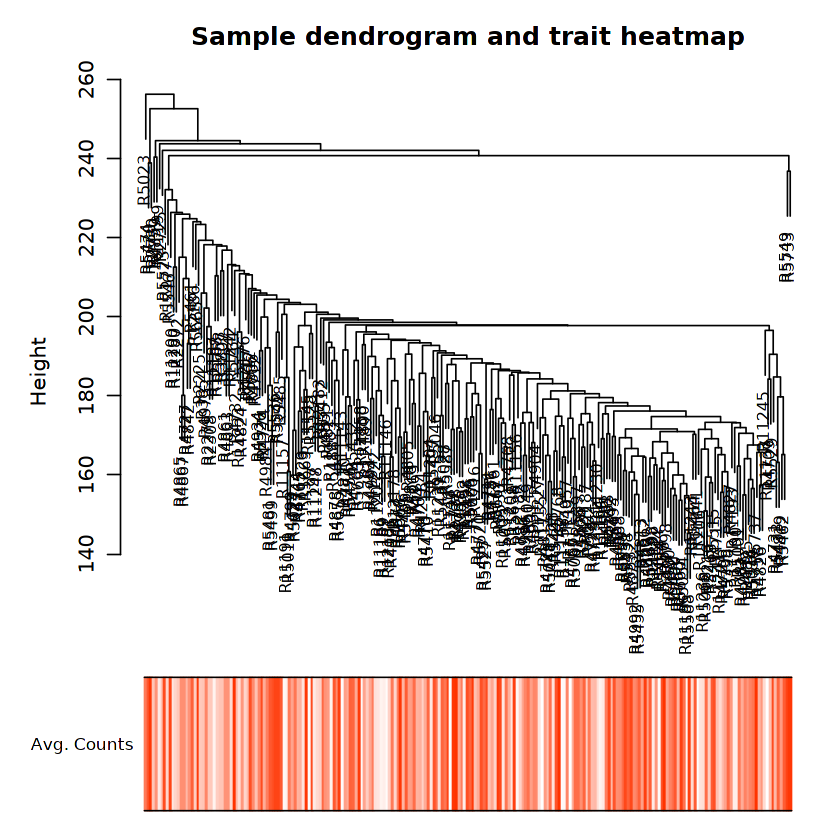

In [12]:
# 1 - Sample dendrogram and trait heatmap
prepare_traits()

pickSoftThreshold: will use block size 2009.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2009 of 22269


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   ..working on genes 2010 through 4018 of 22269
   ..working on genes 4019 through 6027 of 22269
   ..working on genes 6028 through 8036 of 22269
   ..working on genes 8037 through 10045 of 22269
   ..working on genes 10046 through 12054 of 22269
   ..working on genes 12055 through 14063 of 22269
   ..working on genes 14064 through 16072 of 22269
   ..working on genes 16073 through 18081 of 22269
   ..working on genes 18082 through 20090 of 22269
   ..working on genes 20091 through 22099 of 22269
   ..working on genes 22100 through 22269 of 22269
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.   max.k.
1      1    0.070 -44.90          0.974 1.12e+04  1.12e+04 11400.00
2      2    0.064 -18.20          0.931 5.67e+03  5.67e+03  5960.00
3      3    0.215 -18.40          0.936 2.92e+03  2.91e+03  3220.00
4      4    0.409 -15.40          0.944 1.52e+03  1.52e+03  1800.00
5      5    0.539 -11.80          0.950 8.05e+02  7.97e+02  1040.00
6      6    0.652  -9.36          0.96

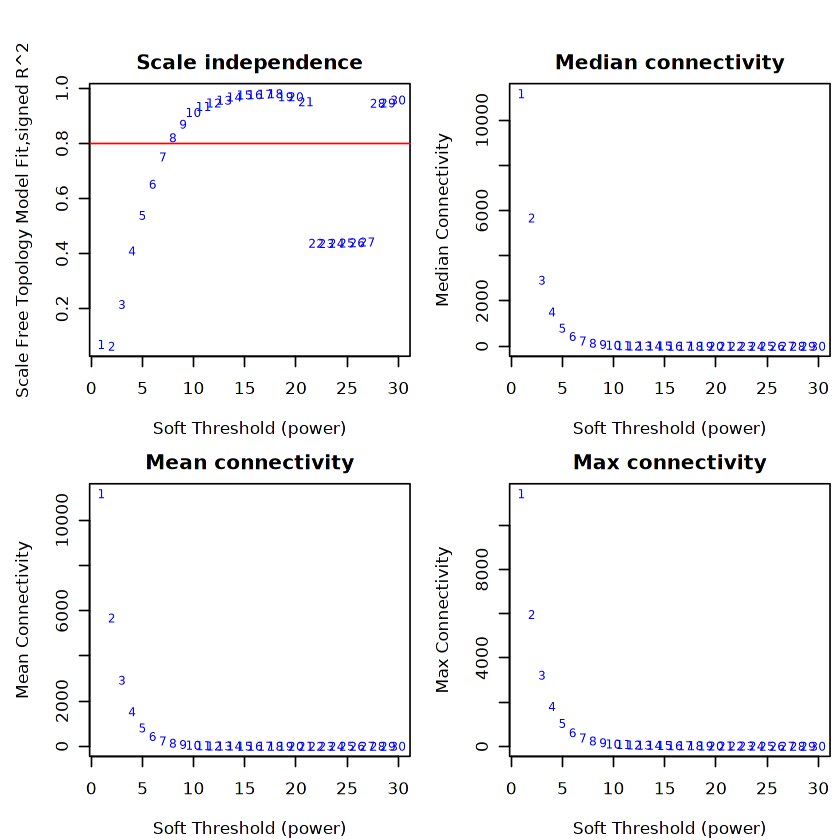

In [13]:
# 2 - Scale Free Topology Model Fit
figure_out_power_parameter()

In [14]:
construct_network()

Allowing parallel execution with up to 16 working processes.
 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 16 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file TOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 2 because their KME is too low.
     ..removing 1 genes from module 5 because their KME is too low.
  ..reassigning 6 genes from module 1 to modules with higher KME.
  ..reassigning 4 genes from module 2 to modules with higher KME.
  ..reassigning 8 genes from module 3 to modules with higher KME.
  ..reassigning 23 genes from module 4 to modules with higher KME.
  

Allowing parallel execution with up to 16 working processes.


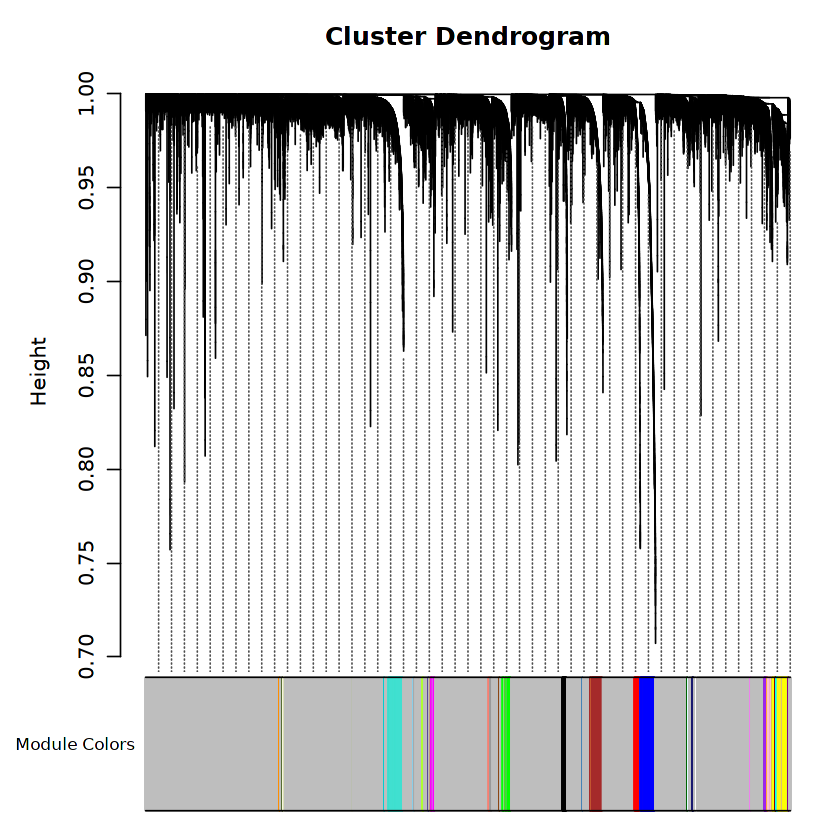

In [15]:
#3 - TOM Dendogram
plot_cluster_dendrogram()

Allowing parallel execution with up to 16 working processes.


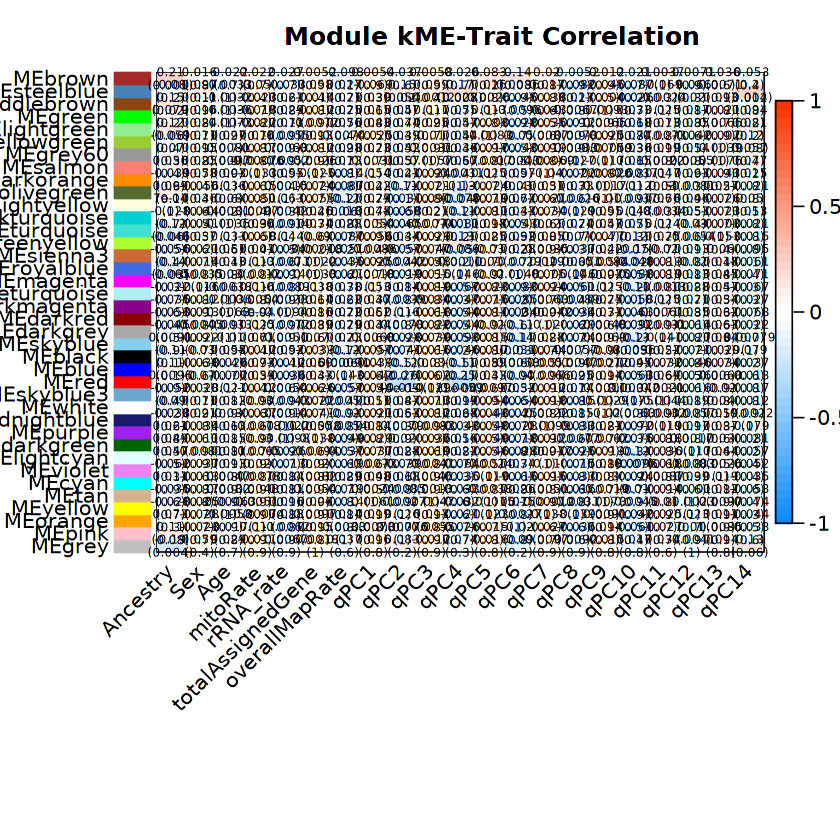

In [16]:
#4 - Module Eigenvalue Correlation with sample's traits
correlate_with_traits()
export_eigengene_tables()

## Repreducibility Information

In [17]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-12 10:46:37 EDT"

    user   system  elapsed 
4092.798 1198.755  630.204 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-12                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package        * version  date       lib source        
 AnnotationDbi    1.52.0   2020-10-27 [1] Bioconductor  
 assertthat       0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports        1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc        0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 Biobase          2.50.0   2020-10-27 [1] Bioconductor  
 BiocGenerics     0.36.1   20